In [62]:
import warnings
import pandas as pd
import numpy as np
import collections

import matplotlib.pyplot as plt
from yellowbrick.text.freqdist import FreqDistVisualizer

########## NLP
# pre-processing 
import re 
import string 
import nltk
from nltk import tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer 
import spacy 
# topic-models 
from sklearn.decomposition import NMF, LatentDirichletAllocation

warnings.filterwarnings('ignore') # turn off warnings 
%matplotlib inline
nlp = spacy.load('en') # load spacy model
en_stopwords = set(stopwords.words('english')) # SKLEARN'S ENGLISH_STOP_WORDS TOO GREEDY
stemmer = SnowballStemmer("english", ignore_stopwords=True)

## Remove irrelevant products

In [3]:
data = pd.read_pickle('/Users/booranium/practicum/amazon/data/data_tokenized') # better to use pickle
data.head()

,asin,helpful,reviewText,overall,summary,description,title,categories_clean,review_length,reviewText_clean,summary_clean,review_all,review_all_clean,review_all_no_punct,review_all_tokens,title_clean,title_tokens,title_tokens_lower,review_tokens_sub
0,0929619730,"[0, 0]",B-flax-D is a regular at our house. It does it...,5.0,Dpes the job well,Contains Organic Cold-Milled Flaxseed\nValuabl...,New Generation B-Flax-D,"Health & Personal Care, Vitamins & Dietary Sup...",224,B-flax-D is a regular at our house. It does it...,B-flax-D is a regular at our house. It does it...,B-flax-D is a regular at our house. It does it...,B-flax-D is a regular at our house. It does it...,B flax D is a regular at our house It does it...,"[B, flax, D, is, a, regular, at, our, house, ,...",New Generation B Flax D,"[New, Generation, B, Flax, D]",new generation b flax d,"[is, regular, our, house, It, does, its, job, ..."
1,0978559088,"[1, 1]",I started taking this after both my parents di...,5.0,Bioavailability is the key,Everyone knows that resveratrol is an amazing ...,Nutrihill Resveratrol Lozenges,"Health & Personal Care, Vitamins & Dietary Sup...",1065,I started taking this after both my parents di...,I started taking this after both my parents di...,I started taking this after both my parents di...,I started taking this after both my parents di...,I started taking this after both my parents di...,"[I, started, taking, this, after, both, my, pa...",Nutrihill Resveratrol Lozenges,"[Nutrihill, Resveratrol, Lozenges]",nutrihill resveratrol lozenges,"[started, taking, this, after, both, my, paren..."
2,0978559088,"[0, 0]",I really liked this product because it stayed ...,5.0,"I can't find this product any longer, and I wi...",Everyone knows that resveratrol is an amazing ...,Nutrihill Resveratrol Lozenges,"Health & Personal Care, Vitamins & Dietary Sup...",767,I really liked this product because it stayed ...,I really liked this product because it stayed ...,I really liked this product because it stayed ...,I really liked this product because it stayed ...,I really liked this product because it stayed ...,"[I, really, liked, this, product, because, it,...",Nutrihill Resveratrol Lozenges,"[Nutrihill, Resveratrol, Lozenges]",nutrihill resveratrol lozenges,"[really, liked, this, product, because, it, st..."
3,0978559088,"[3, 3]","Resveratrol is a polar compound, very insolubl...",5.0,Just the Resveratrol product we need,Everyone knows that resveratrol is an amazing ...,Nutrihill Resveratrol Lozenges,"Health & Personal Care, Vitamins & Dietary Sup...",1422,"Resveratrol is a polar compound, very insolubl...","Resveratrol is a polar compound, very insolubl...","Resveratrol is a polar compound, very insolubl...","Resveratrol is a polar compound, very insolubl...",Resveratrol is a polar compound very insolubl...,"[Resveratrol, is, a, polar, compound, , very, ...",Nutrihill Resveratrol Lozenges,"[Nutrihill, Resveratrol, Lozenges]",nutrihill resveratrol lozenges,"[is, polar, compound, very, insoluble, in, wat..."
4,1427600228,"[3, 3]",I bought several of these bracelets for my YMC...,5.0,The kids love these bracelets,The Zenlet Green Tea Bracelet provides you wit...,Zenlet Green Tea Love Bracelet - All Natural,"Health & Personal Care, Vitamins & Dietary Sup...",186,I bought several of these bracelets for my YMC...,I bought several of these bracelets for my YMC...,I bought several of these bracelets for my YMC...,I bought several of these bracelets for my YMC...,I bought several of these bracelets for my YMC...,"[I, bought, several, of, these, bracelets, for...",Zenlet Green Tea Love Bracelet All Natural,"[Zenlet, Green, Tea, Love, Bracelet, All, Natu...",zenlet green tea love bracelet all natural,"[I, bought, several, of, these, bracelets, for..."


In [4]:
def try_split_3(string):
    ls = string.split(',')
    try:
        return ls[2].strip()
    except:
        pass
    
def try_split_4(string):
    ls = string.split(',')
    try:
        return ls[3].strip()
    except:
        pass    

def try_split_5(string):
    ls = string.split(',')
    try:
        return ls[4].strip()
    except:
        pass

def try_split_6(string):
    ls = string.split(',')
    try:
        return ls[5].strip()
    except:
        pass  

def try_split_7(string):
    ls = string.split(',')
    try:
        return ls[6].strip()
    except:
        pass

In [5]:
data['cat1'] = data.categories_clean.apply(lambda x: x.split(',')[0])
data['cat2'] = data.categories_clean.apply(lambda x: x.split(',')[1].strip())
data['cat3'] = data.categories_clean.apply(try_split_3)
data['cat4'] = data.categories_clean.apply(try_split_4)
data['cat5'] = data.categories_clean.apply(try_split_5)
data['cat6'] = data.categories_clean.apply(try_split_6)
data['cat7'] = data.categories_clean.apply(try_split_7)

In [6]:
data_clean1 = data[data.cat1 == 'Health & Personal Care'] 
#exclude: Cell Phones & Accessories

data_clean2 = data_clean1[data_clean1.cat2 == 'Vitamins & Dietary Supplements'] 
# exclude: Sports Nutrition, Baby & Child Care

data_clean3 = data_clean2[data_clean2.cat3.isin(['Supplements','Vitamins','Minerals', 'Herbal Supplements'])]
# excludes: Multi & Prenatal Vitamins, Weight Loss, Clothing

In [22]:
small = data_clean3[['asin', 'helpful', 'reviewText', 'overall', 'summary', 'description', 'title', 'categories_clean', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7']]

In [25]:
small.reset_index().to_feather('data_clean_v3')

In [3]:
small = pd.read_feather('../data/data_clean_v3')
small.head()

,index,asin,helpful,reviewText,overall,summary,description,title,categories_clean,cat1,cat2,cat3,cat4,cat5,cat6,cat7
0,1,0978559088,"[1, 1]",I started taking this after both my parents di...,5.0,Bioavailability is the key,Everyone knows that resveratrol is an amazing ...,Nutrihill Resveratrol Lozenges,"Health & Personal Care, Vitamins & Dietary Sup...",Health & Personal Care,Vitamins & Dietary Supplements,Supplements,Antioxidants,Resveratrol,None,None
1,2,0978559088,"[0, 0]",I really liked this product because it stayed ...,5.0,"I can't find this product any longer, and I wi...",Everyone knows that resveratrol is an amazing ...,Nutrihill Resveratrol Lozenges,"Health & Personal Care, Vitamins & Dietary Sup...",Health & Personal Care,Vitamins & Dietary Supplements,Supplements,Antioxidants,Resveratrol,None,None
2,3,0978559088,"[3, 3]","Resveratrol is a polar compound, very insolubl...",5.0,Just the Resveratrol product we need,Everyone knows that resveratrol is an amazing ...,Nutrihill Resveratrol Lozenges,"Health & Personal Care, Vitamins & Dietary Sup...",Health & Personal Care,Vitamins & Dietary Supplements,Supplements,Antioxidants,Resveratrol,None,None
3,4,1427600228,"[3, 3]",I bought several of these bracelets for my YMC...,5.0,The kids love these bracelets,The Zenlet Green Tea Bracelet provides you wit...,Zenlet Green Tea Love Bracelet - All Natural,"Health & Personal Care, Vitamins & Dietary Sup...",Health & Personal Care,Vitamins & Dietary Supplements,Herbal Supplements,Green Tea,None,None,None
4,5,1427600228,"[1, 1]",I bought a few the other week just to see what...,5.0,Pleasant Surprise,The Zenlet Green Tea Bracelet provides you wit...,Zenlet Green Tea Love Bracelet - All Natural,"Health & Personal Care, Vitamins & Dietary Sup...",Health & Personal Care,Vitamins & Dietary Supplements,Herbal Supplements,Green Tea,None,None,None


## Split into individual categories

In [4]:
small.groupby('cat3').asin.count()

cat3
Herbal Supplements    63246
Minerals              22339
Supplements           91477
Vitamins              40468
Name: asin, dtype: int64

In [7]:
herbs_only = small[small.cat3 == 'Herbal Supplements']
min_only = small[small.cat3 == 'Minerals']
supp_only = small[small.cat3 == 'Supplements']
vit_only = small[small.cat3 == 'Vitamins']

In [10]:
min_only.cat4.unique()

array(['Iron', 'Calcium', 'Potassium', 'Magnesium', 'Trace Minerals',
       'Chromium', 'Zinc', 'Selenium', 'Manganese', None, 'Copper',
       'Multiminerals', 'Iodine', 'Silicon', 'Colloidal Minerals',
       'Collagen', 'Sodium', 'P-5-P'], dtype=object)

In [9]:
supp_only.cat4.unique()

array(['Antioxidants', 'Enzymes', 'Digestive Supplements',
       'Essential Fatty Acids', None, 'Chondroitin & Glucosamine', 'DHEA',
       'Superfoods', '5-HTP', 'MSM', 'Hyaluronic Acid',
       'Glandular Extracts', 'Royal Jelly', 'Bromelain', 'Fish Oil'],
      dtype=object)

In [8]:
herbs_only.cat4.unique()

array(['Green Tea', None, 'Ginkgo Biloba', 'Echinacea', "St. John's Wort",
       'Saw Palmetto', 'Turmeric', 'Stevia', 'Goldenseal', 'Flaxseed',
       'Cinnamon', 'Garlic', 'Ginger', 'Astragalus', 'Horny Goat Weed',
       'Red Yeast Rice', 'Aloe Vera', 'Milk Thistle', 'Dong Quai',
       'Mushrooms', 'Oregano', 'Yohimbe', 'Black Cohosh', 'Licorice Root',
       'Olive Leaf', 'Evening Primrose', 'Chlorophyll', 'Cranberry',
       'Hawthorn', 'Noni', 'Bilberry', 'Alfalfa', 'Chamomile', 'Triphala',
       'Valerian', 'Ginseng', 'Cayenne', 'Grape Seed Extract',
       'Artichoke', 'Elderberry', 'Nettle', 'Tribulus', 'Maca',
       'Muira Puama', 'Neem', 'Chlorella', 'Spirulina', 'Kava Kava',
       'Marshmallow Root', 'Curcumin'], dtype=object)

In [6]:
vit_only.cat4.unique()

array(['Vitamin E', 'Vitamin B', 'Vitamin A', 'Hair', None, 'Vitamin C',
       'Flavonoids', 'Vitamin D', 'Choline', 'Vitamin K'], dtype=object)

In [12]:
herbs_only.asin.nunique(),\
min_only.asin.nunique(),\
supp_only.asin.nunique(),\
vit_only.asin.nunique()

(10026, 2844, 9213, 4735)

In [13]:
fish_oil_only = supp_only[supp_only.cat4 == 'Fish Oil']

## Preprocessing

from: https://github.com/nicharuc/Collocations/blob/master/cleanreviews.py

In [19]:
def _removeNonAscii(s): return "".join(i for i in s if ord(i)<128) #remove non-ascii characters
reviews = fish_oil_only.reviewText.map(lambda x: _removeNonAscii(x))

#get stop words of all languages
STOPWORDS_DICT = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}
#function to detect language based on # of stop words for particular language
def get_language(text):
    words = set(nltk.wordpunct_tokenize(text.lower()))
    lang = max(((lang, len(words & stopwords)) for lang, stopwords in STOPWORDS_DICT.items()), key = lambda x: x[1])[0]
    if lang == 'english':
        return True
    else:
        return False
#filter for only english comments
eng_reviews=reviews[reviews.apply(get_language)]

#drop duplicates
eng_reviews.drop_duplicates(inplace=True)

#function to clean and lemmatize comments
def cleaner(text):
    #remove punctuations
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    #nopunct = regex.sub(" ", str(text)) # string formatting issue 
    nopunct = regex.sub(" ", text)
    #use spacy to lemmatize comments
    doc = nlp(nopunct, disable=['parser','ner'])
    lemma = [token.lemma_ for token in doc]
    return lemma

#apply function to clean and lemmatize comments
lemmatized = eng_reviews.map(cleaner)

#make sure to lowercase everything
lemmatized = lemmatized.map(lambda x: [word.lower() for word in x])

#turn all comments' tokens into one single list
unlist_reviews = [item for items in lemmatized for item in items]


## Bigrams and Trigrams

from: https://medium.com/@nicharuch/collocations-identifying-phrases-that-act-like-individual-words-in-nlp-f58a93a2f84a

In [22]:
bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(unlist_reviews)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(unlist_reviews)

### Method 1

In [23]:
#bigrams
bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)

#trigrams
trigram_freq = trigramFinder.ngram_fd.items()
trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['trigram','freq']).sort_values(by='freq', ascending=False)

In [24]:
#get english stopwords
en_stopwords = set(stopwords.words('english'))
#function to filter for ADJ/NN bigrams
def rightTypes(ngram):
    if '-pron-' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords or word.isspace():
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False
#filter bigrams
filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]

#function to filter for trigrams
def rightTypesTri(ngram):
    if '-pron-' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords or word.isspace():
            return False
    first_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    third_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in first_type and tags[2][1] in third_type:
        return True
    else:
        return False
#filter trigrams
filtered_tri = trigramFreqTable[trigramFreqTable.trigram.map(lambda x: rightTypesTri(x))]

In [25]:
filtered_tri[:500]

,trigram,freq
171,"(cod, liver, oil)",336
1789,"(fish, oil, supplement)",100
3035,"(fish, oil, pill)",74
1480,"(fish, oil, capsule)",72
2929,"(good, fish, oil)",61
1986,"(omega, 3, fatty)",58
2280,"(fish, oil, product)",39
5405,"(carlson, fish, oil)",39
11264,"(quality, fish, oil)",38
25808,"(liquid, fish, oil)",35


In [90]:
filtered_bi[:500]

,bigram,freq
326119,"(vitamin, c)",3245
187725,"(great, product)",1765
63244,"(vitamin, d3)",1318
139017,"(side, effect)",1016
233299,"(vitamin, e)",929
68499,"(good, price)",846
299083,"(good, product)",781
22501,"(b, complex)",709
254320,"(great, price)",680
301185,"(b, vitamin)",618


### Method 2

In [57]:
#filter for only those with more than 20 occurences
bigramFinder.apply_freq_filter(20)
trigramFinder.apply_freq_filter(20)
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)
trigramPMITable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.pmi)), columns=['trigram','PMI']).sort_values(by='PMI', ascending=False)

In [86]:
trigramPMITable[:500]

,trigram,PMI
0,"(osteo, bi, flex)",31.918917
1,"(restless, leg, syndrome)",26.644287
2,"(gastric, bypass, surgery)",25.658198
3,"(112, digital, premium)",25.334510
4,"(coffee, bean, extract)",25.009532
5,"(green, coffee, bean)",24.998307
6,"(hj, 112, digital)",24.742631
7,"(alpha, lipoic, acid)",24.109153
8,"(extra, virgin, olive)",23.742316
9,"(omron, hj, 112)",23.676743


In [85]:
bigramPMITable[:500]

,bigram,PMI
0,"(mad, hippie)",16.259502
1,"(linus, pauling)",16.147475
2,"(aloe, vera)",15.921261
3,"(bi, flex)",15.891588
4,"(wal, mart)",15.707296
5,"(macular, degeneration)",15.566252
6,"(osteo, bi)",15.550890
7,"(la, beaute)",15.516277
8,"(lypo, spheric)",15.308860
9,"(sub, lingual)",15.047342


### Method 3

In [60]:
bigramTtable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.student_t)), columns=['bigram','t']).sort_values(by='t', ascending=False)
trigramTtable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.student_t)), columns=['trigram','t']).sort_values(by='t', ascending=False)
#filters
filteredT_bi = bigramTtable[bigramTtable.bigram.map(lambda x: rightTypes(x))]
filteredT_tri = trigramTtable[trigramTtable.trigram.map(lambda x: rightTypesTri(x))]

In [81]:
len(filteredT_bi)

1189

### Replace grams in text

In [26]:
trigram_list = filtered_tri[filtered_tri.freq > 20].trigram.tolist()
bigram_list = filtered_bi[filtered_bi.freq > 20].bigram.tolist()

In [27]:
# replace the word with selected ngram
def trigram_concat(text):
    text1 = text.lower()
    for ngram in trigram_list:
        raw = str(' '.join(ngram))
        clean = str('_'.join(ngram))
        text1 = text1.replace(raw, clean)
    return text1

In [28]:
# replace the word with selected ngram
def bigram_concat(text):
    text1 = text.lower()
    for ngram in bigram_list:
        raw = str(' '.join(ngram))
        clean = str('_'.join(ngram))
        text1 = text1.replace(raw, clean)
    return text1

In [29]:
trigrammed = eng_reviews.map(trigram_concat)

In [30]:
bigrammed = trigrammed.map(bigram_concat)

In [32]:
bigrammed[:10]

17067    i was recommended these by a rep @ whole foods...
17068    i don't have science to support my claims but ...
17069    i bought this items previously - but unfortuna...
17070    this is a great supplement for dogs, especiall...
17971    one tablet is all you need.  cod_liver_oil is ...
18073    i always use solgar cod_liver_oil and never di...
18074    after reading a newspaper article about resear...
18075    the shipping was slow but free so i can't comp...
18076    after checking on all the cod_liver_oil_supple...
18077    i've been using it and so has husband for quit...
Name: reviewText, dtype: object

In [194]:
#pd.DataFrame(bigrammed).to_pickle('reviews_gram_concat')

## Plot token frequency

In [4]:
#data = pd.read_pickle('reviews_gram_concat')

In [38]:
def spacy_stem(toke):
    doc = nlp(toke, disable=['parser','ner'])
    lemma = [token.lemma_ for token in doc]
    return lemma

In [63]:
custom_punct = string.punctuation.replace('_','')

def tokenize(text):   
    text = text.lower()
    text = re.sub('[' + custom_punct + '0-9\\r\\t\\n]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if len(w) > 2]
    tokens = [w for w in tokens if not w in en_stopwords]
    tokens = [stemmer.stem(w) for w in tokens]
    
    return tokens 

vectorizer = CountVectorizer(tokenizer = tokenize) # remove stop words
docs = vectorizer.fit_transform(bigrammed)
features = vectorizer.get_feature_names()

In [64]:
features

['_fatty_acid',
 '_fish',
 '_fish_oil',
 'abandon',
 'abdomin',
 'abil',
 'abl',
 'abnorm',
 'absent',
 'absolut',
 'absolutley',
 'absorb',
 'absorpt',
 'abstract',
 'abund',
 'abus',
 'abut',
 'abyss',
 'academi',
 'accept',
 'access',
 'accid',
 'accident',
 'accompani',
 'accomplish',
 'accord',
 'accordin',
 'account',
 'accumul',
 'accur',
 'accutan',
 'ach',
 'achi',
 'achiev',
 'acid',
 'acl',
 'acn',
 'acomplish',
 'across',
 'act',
 'action',
 'activ',
 'acttual',
 'actual',
 'acuiti',
 'acupuncturist',
 'acut',
 'ad',
 'adam',
 'adapt',
 'aday',
 'add',
 'addit',
 'address',
 'adenoid',
 'adequ',
 'adh',
 'adhd',
 'adher',
 'adhes',
 'adjust',
 'administ',
 'admir',
 'admit',
 'adren',
 'adult',
 'adultswww',
 'advanc',
 'advantag',
 'advers',
 'advertis',
 'advertsi',
 'advic',
 'advil',
 'advis',
 'advoc',
 'aesthet',
 'affair',
 'affect',
 'affection',
 'afffect',
 'affili',
 'afford',
 'afghanistan',
 'aforement',
 'afraid',
 'africa',
 'african',
 'afteral',
 'aftereffe

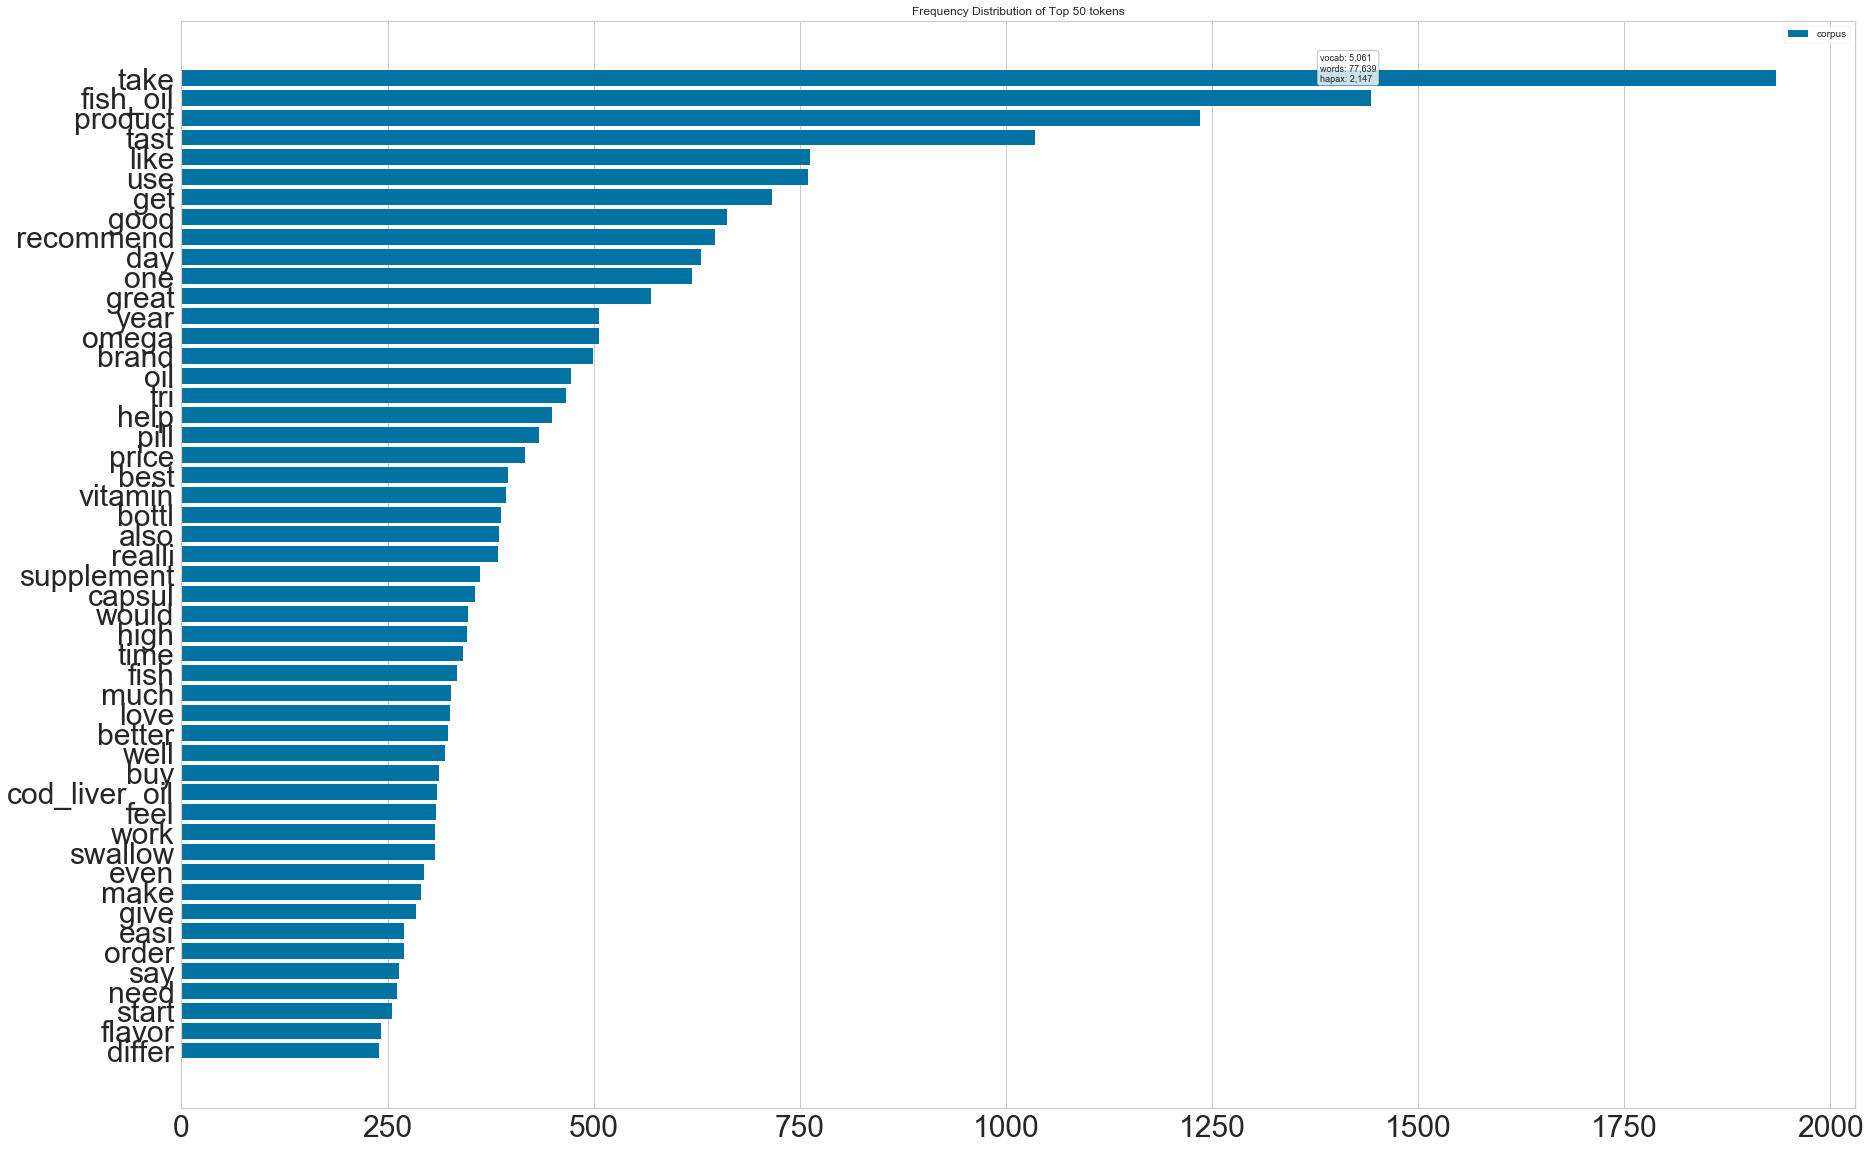

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 20))  # the size you want
plt.tick_params(labelsize=30)

visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()

## NMF

In [66]:
feature_names = vectorizer.get_feature_names()

In [77]:
for n in [4,5,6,7]:
    nmf = NMF(n_components=n, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(docs)
    # if n_components=no_topics --> all features are kept
    print('Num. Topics: ', n)
    num_top_words = 20
    for topic_idx, topic in enumerate(nmf.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))
    print('')

Num. Topics:  4
Topic 0:
take day get year vitamin pill start one work help month feel recommend notic everi sinc time supplement make need
Topic 1:
fish_oil omega dha epa supplement fatty_acid brand also get high fish recommend acid carlson ratio fish_burp oil capsul tri best
Topic 2:
product use recommend price great one omega year order high well amazon good would brand time qualiti bottl help natur
Topic 3:
tast like oil good tri realli fish smell get flavor lemon one fishi use cod_liver_oil bottl would swallow even orang

Num. Topics:  5
Topic 0:
take day year get pill start one work help vitamin month feel notic recommend everi sinc time make realli differ
Topic 1:
fish_oil brand tri carlson one fish_burp epa best dha recommend price mani buy fish get high also use kirkland benefit
Topic 2:
product use recommend price one great year order brand amazon well would good time qualiti high help bottl best natur
Topic 3:
tast like oil good tri realli fish get smell flavor lemon fishi o

In [71]:
for n in [4,5,6,7]:
    lda = LatentDirichletAllocation(n_topics=n, max_iter=5, learning_method='online',\
                                    learning_offset=50.,random_state=0).fit(docs)
    print('Num. Topics: ', n)
    num_top_words = 10
    for topic_idx, topic in enumerate(lda.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))
    print('')

Num. Topics:  4
Topic 0:
cinnamon green pastur butter clo teeth ferment wild_alaskan_salmon_oil tingl salmon
Topic 1:
inflammatori anti cold properti eczema rid babi emuls scott mother
Topic 2:
take fish_oil product tast like use get one good day
Topic 3:
cardio extract absorb mango formul fear antioxid autism reach chemic

Num. Topics:  5
Topic 0:
mgtotal wild_alaskan_salmon_oil turmer lovaza ginger cutar swanson countri caviti garlic
Topic 1:
cold emuls scott zero mother ten infect usp grade ear
Topic 2:
take fish_oil product tast like use get one good day
Topic 3:
cardio formul pharmacist fear absorb enhanc nexium autism choke iron
Topic 4:
cinnamon pastur tingl ferment green virgin ice chemic butter tooth

Num. Topics:  6
Topic 0:
lovaza cutar countri treatment pine releas medium neighbor prescript caus
Topic 1:
anti inflammatori properti cold eczema rid cardio emuls scott infect
Topic 2:
take fish_oil product tast like use get one good day
Topic 3:
fear choke bio absorb allergen r